# Homework 5

In [1]:
import cvxpy as cp
import numpy as np

## A14.3 Optimal amplifier gains

In [2]:
# construct the system
n = 4
Atot = 10000
alpha = [10**-5,10**-2,10**-2,10**-2]
M = [0.1, 5, 10, 10]
Amax = [40,40,40,20]

t = cp.Variable(1, pos = True)
a = cp.Variable(n, pos = True)
frac_num = 0
for i in range(n):
    prod = cp.prod(cp.square(a[i:n]))
    frac_num += prod*cp.square(alpha[i])

frac_den = []
for i in range(n):
    prod = cp.prod(cp.square(a[i+1:n]))
    frac_den.append(prod*cp.square(M[i])*t)
frac_den = cp.min(cp.hstack(frac_den))

constraints = [frac_num/frac_den <= 1,
               cp.prod(a) == Atot,
               a <= Amax]

problem = cp.Problem(cp.Minimize(t), constraints)
assert problem.is_dgp()
problem.solve(gp=True, solver=cp.CLARABEL)

0.06264006268986533

In [193]:
a_opt = a.value
frac_num = 0
for i in range(n):
    prod = np.prod(np.square(a_opt[i:n]))
    frac_num += prod*np.square(alpha[i])

frac_den = []
for i in range(n):
    prod = np.prod(np.square(a_opt[i+1:n]))
    frac_den.append(prod*np.square(M[i]))
frac_den = np.min(np.hstack(frac_den))
D = np.sqrt(frac_den/frac_num)

# print results
print("The optimal gains are:", a.value)
print("The optimal dynamic range is:", D)

The optimal gains are: [39.99999997 39.99998593  6.24990652  1.00001531]
The optimal dynamic range is: 3.9955255206215643


## 17.4 Bounding portfolio risk with incomplete covariance information. C

In [100]:
# compute sigma_wc^2
x = np.array([0.1, 0.2, -0.05, 0.1])
Sigma = cp.Variable((4,4), symmetric = True)
constraints = [
    Sigma >> 0,
    Sigma[0,0] == 0.2,
    Sigma[1,1] == 0.1,
    Sigma[2,2] == 0.3,
    Sigma[3,3] == 0.1,
    Sigma[0,1] >= 0,
    Sigma[0,2] >= 0,
    Sigma[1,2] <= 0,
    Sigma[1,3] <= 0,
    Sigma[2,3] >= 0
]

problem = cp.Problem(cp.Maximize(cp.quad_form(x,Sigma)), constraints)
problem.solve()

0.015166101233105876

In [101]:
# print results
print("The optimal value of the problem is", problem.value)
print("The worse-case risk of the portfolio return is", np.sqrt(problem.value))
print("The associated Sigma covariance matrix is: ")
Sigma.value

The optimal value of the problem is 0.015166101233105876
The worse-case risk of the portfolio return is 0.12315072567023662
The associated Sigma covariance matrix is: 


array([[ 2.00000000e-01,  9.33324323e-02,  9.31686603e-07,
         8.30130856e-02],
       [ 9.33324323e-02,  1.00000000e-01, -1.09983027e-01,
        -6.03504495e-07],
       [ 9.31686603e-07, -1.09983027e-01,  3.00000000e-01,
         1.77084868e-02],
       [ 8.30130856e-02, -6.03504495e-07,  1.77084868e-02,
         9.99999995e-02]])

In [103]:
# compare with Sigma being diagonal
diag = np.array([0.2, 0.1, 0.3, 0.1])
Sigma = np.diag(diag)
# compute sigma_wc^2
sigma_wc = np.sqrt(np.dot(x,np.dot(Sigma,x)))
print("The worse-case risk of the portfolio return when Sigma is diagonal", sigma_wc)

The worse-case risk of the portfolio return when Sigma is diagonal 0.08803408430829505


## 17.6 Option price bounds

In [143]:
# there are 7 assets in total, risk-free asset, underlying stock, two call, two put, and one collar
n_scenarios, n_assets = 200, 7
y = cp.Variable(n_scenarios)
p_n = cp.Variable(1)
S_scenarios = np.linspace(0.5, 2, n_scenarios)
F, C = 0.9, 1.15
p = [1, 1, 0.06, 0.03, 0.02, 0.01, p_n]

# construct V matrix
V = np.zeros((n_scenarios, n_assets))
V[:,0] = 1.05 # value of risk-free asset
V[:,1] = S_scenarios # value of underlying stock
V[:,2] = np.maximum(0, S_scenarios - 1.1) # value of call at strike 1.1
V[:,3] = np.maximum(0, S_scenarios - 1.2) # value of call at strike 1.2
V[:,4] = np.maximum(0, 0.8 - S_scenarios) # value of put at strike 0.8
V[:,5] = np.maximum(0, 0.7 - S_scenarios) # value of put at strike 0.7
V[:,6] = np.minimum(np.maximum(S_scenarios,F), C)

# construct the problem
constraints = [
    V.T @ y == cp.hstack(p),
    y >=0
]

objective_ub = cp.Maximize(p_n)
objective_lb = cp.Minimize(p_n)
problem = cp.Problem(objective_ub, constraints)
problem.solve()
ub = problem.value
problem = cp.Problem(objective_lb, constraints)
problem.solve()
lb = problem.value
print("The range of prices for this collar is:", [lb, ub])

The range of prices for this collar is: [0.9849999999999399, 1.0173313492063338]


## 18.7 Least-cost road grading

In [197]:
import matplotlib.pyplot as plt

# Least-cost road grading

n = 100
d = 1  # distance between points

# Elevation of the road
e = 5 * np.sin(np.arange(1, n + 1) / n * 3 * np.pi) + np.sin(
    np.arange(1, n + 1) / n * 10 * np.pi
)

# Constraints
D1 = 0.08  # the road grade should never be greater than 8%
D2 = 0.025  # the road grade should never change faster than 25% over 10 meters
D3 = 0.005  # a further constraint on the smoothness of the road.

# Cut and fill function coefficients
alpha_fill = 2
beta_fill = 30
alpha_cut = 12
beta_cut = 1

# # Plot cost functions
# elevation = np.arange(0, 10.1, 0.1)
# cost_fill = alpha_fill * elevation**2 + beta_fill * elevation
# cost_cut = alpha_cut * elevation**2 + beta_cut * elevation

In [198]:
# construct problem
h = cp.Variable(n)

constraints = [
    cp.abs(h[1:] - h[:-1]) <= D1,
    cp.abs(h[2:] - 2 * h[1:-1] + h[:-2]) <= D2,
    cp.abs(h[3:] - 3 * h[2:-1] + 3 * h[1:-2] - h[:-3]) <= D3,
]

fill_func = lambda el: alpha_fill * el**2 + beta_fill * el
cut_func  = lambda el: alpha_cut * el**2 + beta_cut * el
cost = cp.sum(fill_func(cp.pos(h - e)) + cut_func(cp.pos(e - h)))

problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve(solver=cp.CLARABEL)

7562.816158963502

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


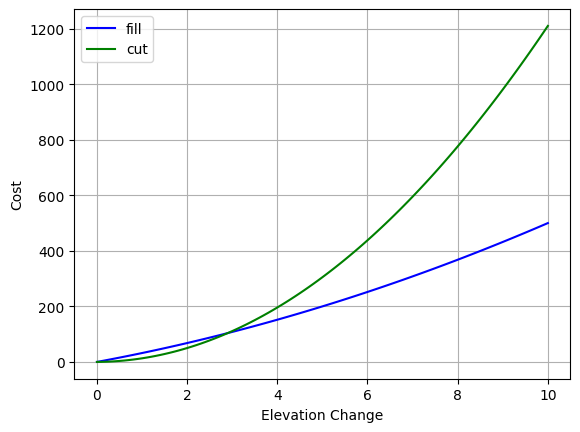

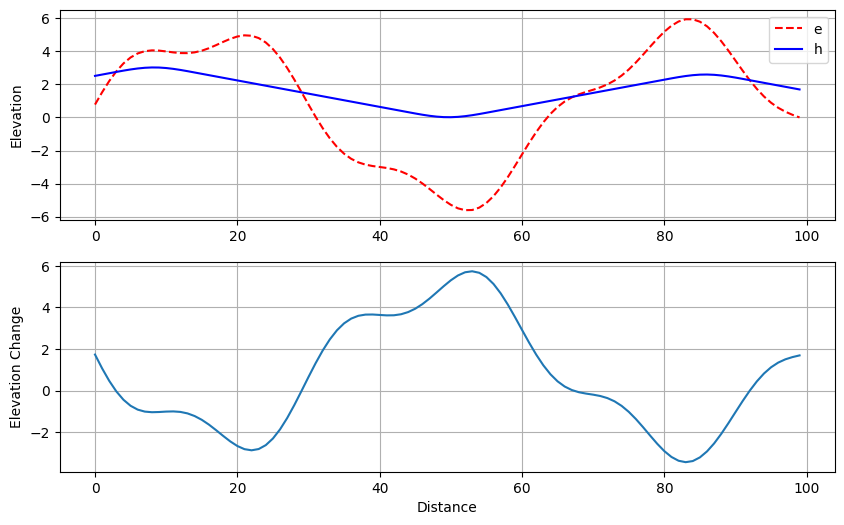

In [200]:
# plot results
plt.figure()
plt.plot(elevation, cost_fill, "b", label="fill")
plt.plot(elevation, cost_cut, "g", label="cut")
plt.xlabel("Elevation Change")
plt.ylabel("Cost")
plt.legend()
plt.grid()
plt.savefig("road_grading_cost_function.eps")
plt.show()

if __name__ == "__main__":
    # Replace h with your solution
    h = h.value

    # Plot elevation profiles
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(np.arange(n) * d, e, "--r", label="e")
    plt.plot(np.arange(n) * d, h, "b", label="h")
    plt.ylabel("Elevation")
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(n) * d, h - e)
    plt.ylabel("Elevation Change")
    plt.xlabel("Distance")
    plt.grid()

    plt.show()

## A20.13 Optimal operation of a microgrid

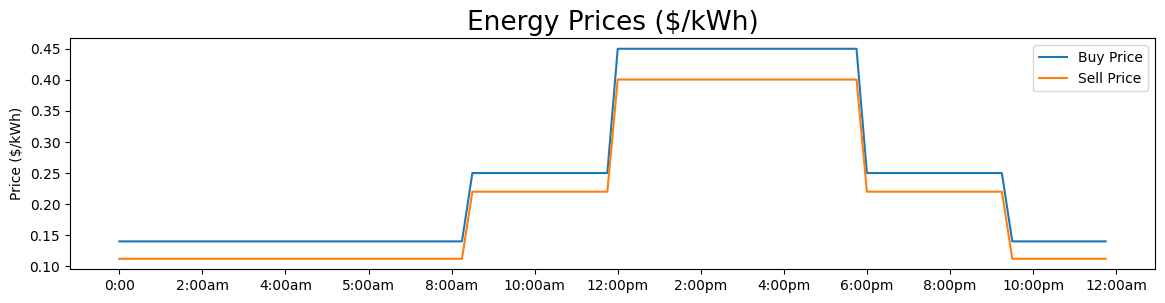

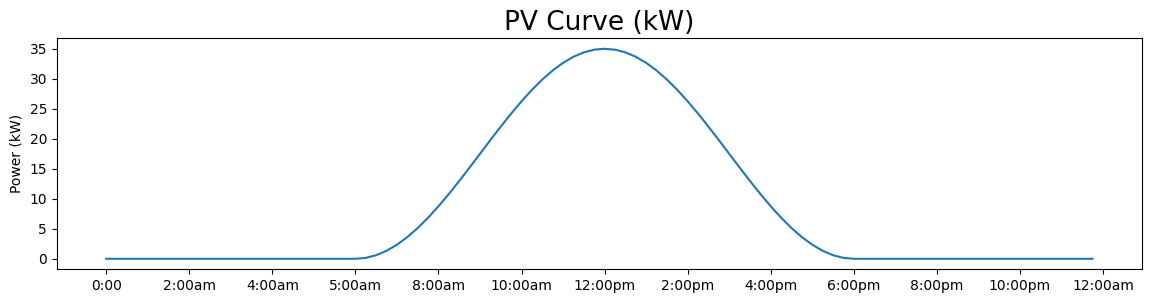

In [203]:
PLOT_FIGURES = True  # True to plot figures, false to suppress plots

N = 96  # Number of periods in the day (so each interval 15 minutes)

# Convenience variables for plotting
fig_size = (14, 3)
xtick_vals = [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96]
xtick_labels = (
    "0:00",
    "2:00am",
    "4:00am",
    "5:00am",
    "8:00am",
    "10:00am",
    "12:00pm",
    "2:00pm",
    "4:00pm",
    "6:00pm",
    "8:00pm",
    "10:00pm",
    "12:00am",
)

#############################################
# Price data generation - price values and intervals based off of PG&E Time Of Use plans
#############################################
partial_peak_start = 34  # 08:30
peak_start = 48  # 12:00
peak_end = 72  # 18:00 (6:00pm)
partial_peak_end = 86  # 21:30 (9:30pm)

off_peak_inds = np.concatenate(
    [np.arange(partial_peak_start), np.arange(partial_peak_end, N)]
)
partial_peak_inds = np.concatenate(
    [np.arange(partial_peak_start, peak_start), np.arange(peak_end, partial_peak_end)]
)
peak_inds = np.arange(peak_start, peak_end)

# rates in $ / kWh
off_peak_buy = 0.14
partial_peak_buy = 0.25
peak_buy = 0.45

# Rate cuts from buy prices to get sell prices
off_peak_perc_cut = 0.20
partial_peak_perc_cut = 0.12
peak_perc_cut = 0.11

off_peak_sell = (1 - off_peak_perc_cut) * off_peak_buy
partial_peak_sell = (1 - partial_peak_perc_cut) * partial_peak_buy
peak_sell = (1 - peak_perc_cut) * peak_buy

# Combine the buy and sell prices into the price vectors
R_buy = np.zeros(N)
R_buy[off_peak_inds] = off_peak_buy
R_buy[partial_peak_inds] = partial_peak_buy
R_buy[peak_inds] = peak_buy

R_sell = np.zeros(N)
R_sell[off_peak_inds] = off_peak_sell
R_sell[partial_peak_inds] = partial_peak_sell
R_sell[peak_inds] = peak_sell

# Plot the prices
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(R_buy, label="Buy Price")
    plt.plot(R_sell, label="Sell Price")
    plt.legend()
    plt.ylabel("Price ($/kWh)")
    plt.title("Energy Prices ($/kWh)", fontsize=19)
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()


#############################################
# Solar data generation
#############################################
# Just something simple: a shifted cosine wave, squared to smooth edges, peak at noon
shift = N / 2
p_pv = np.power(np.cos((np.arange(N) - shift) * 2 * np.pi / N), 2)

scale_factor = 35
p_pv = p_pv * scale_factor
p_pv = np.maximum(p_pv, 0)
p_pv[: int(shift / 2)] = 0
p_pv[-int(shift / 2) :] = 0

# Plot it
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_pv)
    plt.title("PV Curve (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()


In [204]:
#############################################
# Load Data Generation (using cvx)
#############################################
# Fit a curve to some handpicked points and constrain the end points
# to match and the derivative at the end to be the same at the beginning

# points to fit to
points = [
    [0, 7],
    [10, 8],
    [20, 10],
    [28, 15],
    [36, 21],
    [45, 23],
    [52, 21],
    [56, 18],
    [60, 22.5],
    [66, 24.3],
    [70, 25],
    [73, 24],
    [83, 19],
    [95, 7],
]
points = np.array(points, dtype=int)

# Formulate an optimization problem that minimizes the error of
# the fit while also minimizing the 2nd order difference of the function
p_fit = cp.Variable(N)
obj_val = 0
# Add periodicity constraints
constr = [p_fit[0] == p_fit[-1]]  # Constraint the end points to match
constr += [
    (p_fit[1] - p_fit[0]) == (p_fit[-1] - p_fit[-2])
]  # constraint deriv at endpoints to match
# Loss for fitting the data points
for pt in points:
    obj_val += cp.square(p_fit[pt[0]] - pt[1])

# Loss for 2nd order smoothness (weight parameter chosen from weight twiddling)
for i in range(N):
    obj_val += 100 * cp.square(p_fit[(i + 1) % N] - 2 * p_fit[i] + p_fit[(i - 1) % N])

obj = cp.Minimize(obj_val)
prob = cp.Problem(obj, constr)
prob.solve()
p_fit = p_fit.value
p_ld = p_fit

In [237]:
#############################################
# Battery and Grid Line Constraint Values
#############################################
# Max charge and discharge rates
D = 10  # Max discharge rate (kW)
C = 8  # Max charge rate (kW)
Q = 27  # Max energy (kWh)

p_grid = cp.Variable(N)
p_batt = cp.Variable(N)
q = cp.Variable(N)

objective = 0.25*R_sell @ p_grid + 0.25*(R_buy-R_sell) @ (cp.pos(p_grid))
constraints = [
    p_grid + p_batt + p_pv == p_ld,
    q[0] == q[-1] - 0.25*p_batt[-1],
    q[1:] == q[:-1] - 0.25*p_batt[:-1],
    -q <= 0,
    q <= Q,
    -p_batt <= C,
    p_batt <= D,
]
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve(solver=cp.CLARABEL)
print("Optimal cost:", problem.value)

Optimal cost: 32.7673251364679


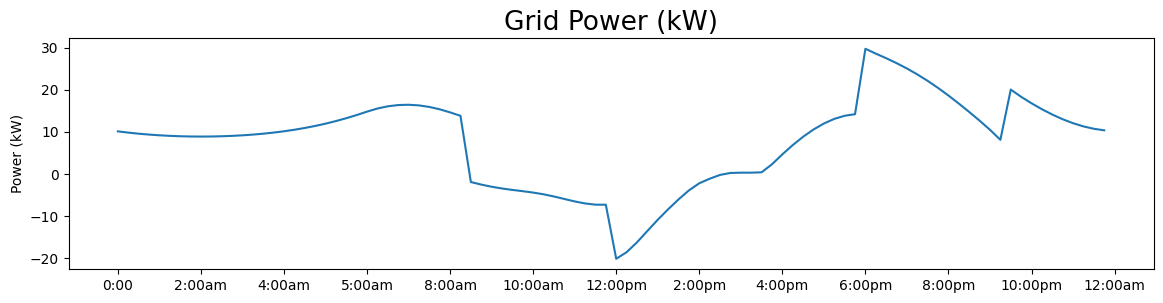

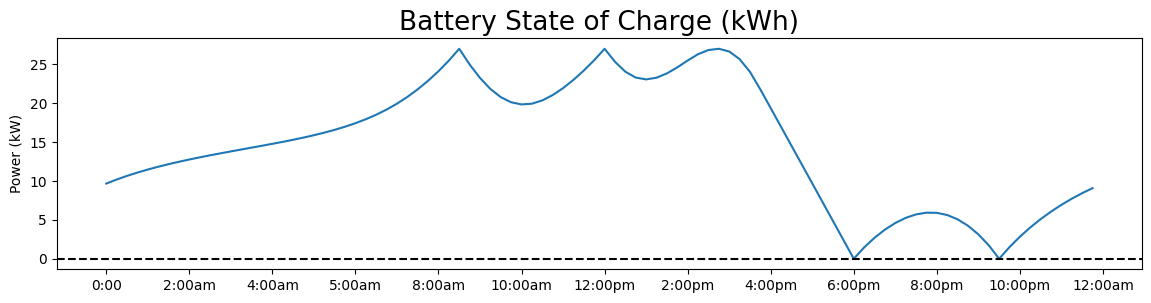

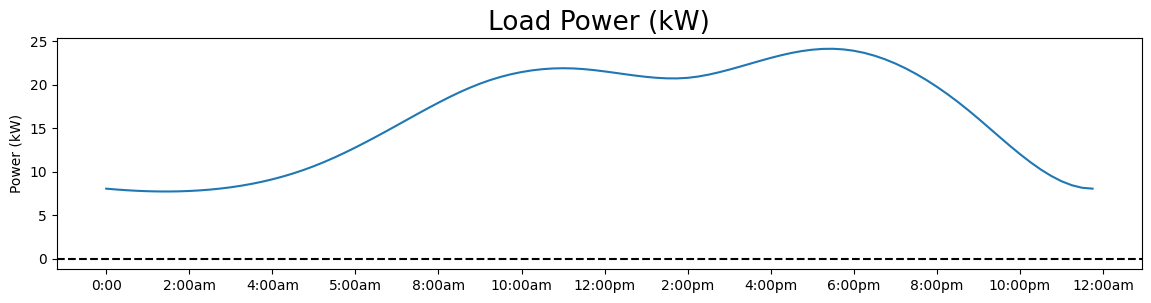

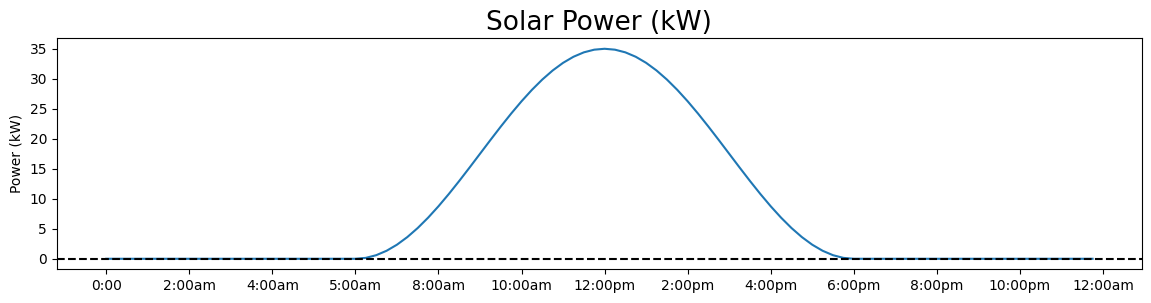

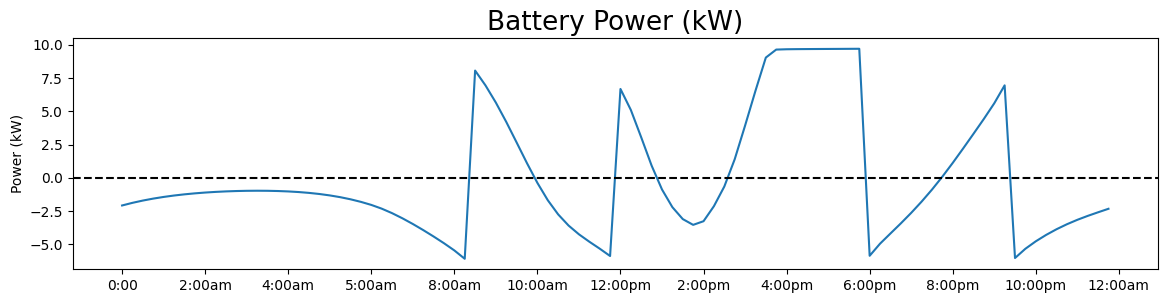

'\nFinal list of values generated:\n\nN (scalar): number of intervals we split the day into\nR_buy (vector, $/kWh): prices one can buy energy at from grid in given interval\nR_sell (vector, $/kWh): prices one can sell energy at to grid in given interval\np_pv (vector, kW): power generated by solar\np_ld (vector, kW): power demands of load\nD (scalar, kW): max discharge rate of battery\nC (scalar, kW): max charge rate of battery\nQ (scalar, kWh): max energy of battery\n'

In [235]:
# Plot the curve
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_grid.value)
    #    plt.plot(points[:,0], points[:,1], 'o') # For plotting the interpolation points
    plt.title("Grid Power (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()

if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(q.value)
    plt.axhline(0, color="black", linestyle="--")
    plt.title("Battery State of Charge (kWh)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()



# For reference, plot the net load curve: load - solar
# Aside: the shape of this curve is referred to as "the duck curve"
# by some people in energy (since the shape looks like a duck on profile), and
# is a result of renewable generation displacing load demand in the day.
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_ld)
    plt.axhline(0, color="black", linestyle="--")
    plt.title("Load Power (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()

if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_pv)
    plt.axhline(0, color="black", linestyle="--")
    plt.title("Solar Power (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()

if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_batt.value)
    plt.axhline(0, color="black", linestyle="--")
    plt.title("Battery Power (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()



"""
Final list of values generated:

N (scalar): number of intervals we split the day into
R_buy (vector, $/kWh): prices one can buy energy at from grid in given interval
R_sell (vector, $/kWh): prices one can sell energy at to grid in given interval
p_pv (vector, kW): power generated by solar
p_ld (vector, kW): power demands of load
D (scalar, kW): max discharge rate of battery
C (scalar, kW): max charge rate of battery
Q (scalar, kWh): max energy of battery
"""

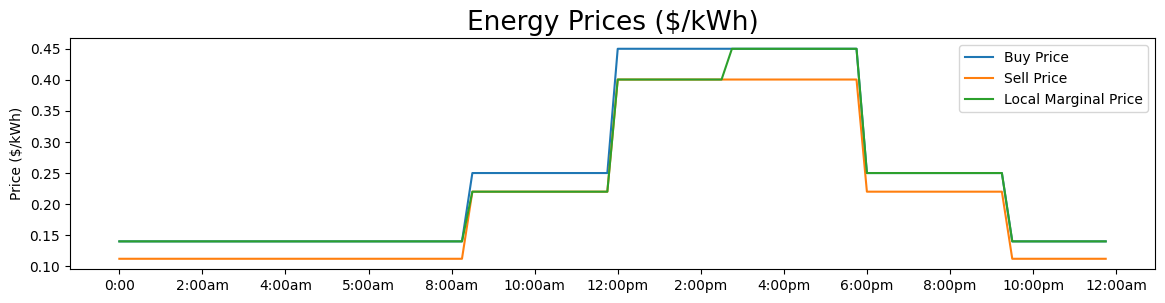

In [249]:
# Plot dual
v = problem.constraints[0].dual_value
LMP = -4*v

if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(R_buy, label="Buy Price")
    plt.plot(R_sell, label="Sell Price")
    plt.plot(LMP, label = "Local Marginal Price")
    plt.legend()
    plt.ylabel("Price ($/kWh)")
    plt.title("Energy Prices ($/kWh)", fontsize=19)
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()


In [254]:
# LMP paid by load, pv, battery, and grid
lmp_load = -v @ p_ld
lmp_pv = -v @ p_pv
lmp_batt = -v @ p_batt.value
lmp_grid = -v @ p_grid.value

print("LMP paid by load:", lmp_load)
print("LMP paid by pv:", lmp_pv)
print("LMP paid by battery:", lmp_batt)
print("LMP paid by grid:", lmp_grid)
print("LMP paid by grid + battery + pv:", lmp_grid + lmp_batt + lmp_pv)

LMP paid by load: 107.58803403416283
LMP paid by pv: 66.45070890950753
LMP paid by battery: 8.369999979534755
LMP paid by grid: 32.767325145120566
LMP paid by grid + battery + pv: 107.58803403416285


In [251]:
lmp_load

107.58803403416283